In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats

In [2]:
df = pd.read_csv('C:\\Users\\sever\\OneDrive\\Desktop\\Responsible Data Science\\data\\training_v2.csv')

In [3]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Only select the gender column

In [4]:
male = df[df['gender'] == 'M']
female = df.drop(male.index)

In [5]:
malePercentage = male.size * 100 / df.size
femalePercentage = 100 - malePercentage

In [6]:
malePercentage

53.9389181468276

In [7]:
femalePercentage

46.0610818531724

Visualize distribution

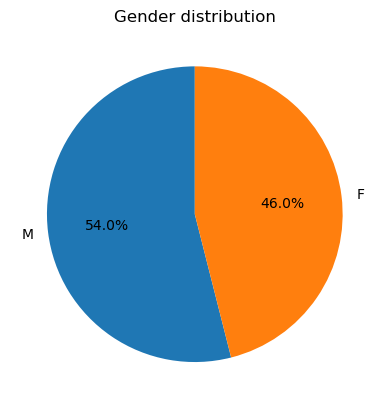

In [8]:
# Count the number of male and female patients in the dataframe
gender_counts = df['gender'].value_counts()

# Plot the gender distribution
gender_counts.plot(kind = 'pie', startangle = 90, autopct = '%1.1f%%')
plt.title('Gender distribution')
plt.ylabel('')
plt.show()

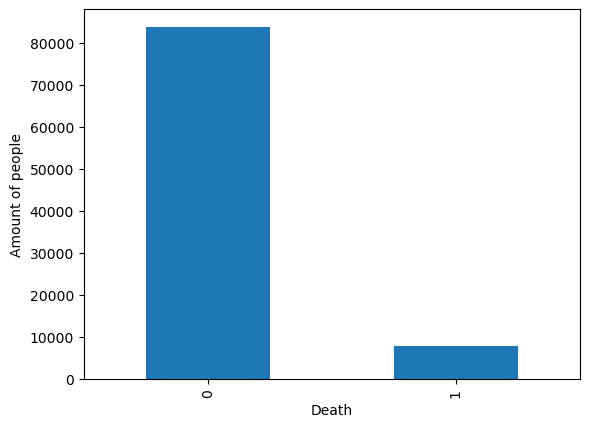

In [9]:
#Visualize statistics concerning hospital deaths
death_counts = df['hospital_death'].value_counts().sort_index()
death_counts.plot(kind='bar')
plt.xlabel('Death')
plt.ylabel('Amount of people')
plt.show()

In [10]:
#Create mask
mask = df['apache_4a_hospital_death_prob'] < 0.8
df['death_approximation'] = np.where(mask, 0, 1)

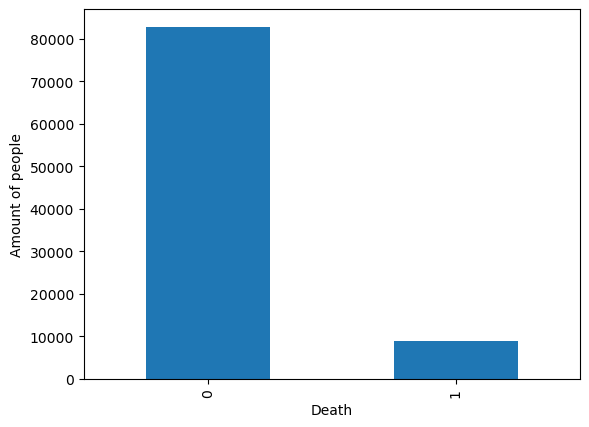

In [11]:
death_counts = df['death_approximation'].value_counts().sort_index()
death_counts.plot(kind='bar')
plt.xlabel('Death')
plt.ylabel('Amount of people')
plt.show()

Find the correlation between age and potentially poor physical state

In [12]:
#compute mean age, mean hospital death probability, mean ICU death probability
meanAge = df['age'].mean()
mean_hdp = df['apache_4a_hospital_death_prob'].mean()
mean_icudp = df['apache_4a_icu_death_prob'].mean()

Impute data

In [13]:
df['age'] = df['age'].fillna(meanAge)
df['apache_4a_hospital_death_prob'] = df['apache_4a_hospital_death_prob'].fillna(mean_hdp)
df['apache_4a_icu_death_prob'] = df['apache_4a_icu_death_prob'].fillna(mean_icudp)

Ensure that no more NaN values occur in any of our relevant 3 columns

In [14]:
flag_age = df['age'].isna().any()
flag_hdp = df['apache_4a_hospital_death_prob'].isna().any()
flag_icudp = df['apache_4a_icu_death_prob'].isna().any()

flag_age or flag_hdp or flag_icudp

False

Compute sum of hospital death probability and icu death probability to determine the overall state of the patient

In [15]:
df['death_aggregate'] = df['apache_4a_hospital_death_prob'] + df['apache_4a_icu_death_prob']
df['death_aggregate']

0        0.150000
1        0.760000
2        0.000000
3        0.070000
4        0.130742
           ...   
91708    0.170000
91709    0.050000
91710    0.070000
91711    0.090000
91712    0.270000
Name: death_aggregate, Length: 91713, dtype: float64

In [16]:
correlation_coefficient, p_value = scipy.stats.pearsonr(df['age'], df['death_aggregate'])

In [17]:
correlation_coefficient

0.10734026546097311

In [18]:
p_value

3.986111761546823e-233

In [19]:
over = df[df['age'] > 55]['death_aggregate']
under = df[df['age'] <= 55]['death_aggregate']

# Perform a t-test to compare the means of the two groups
t_stat, p_val = stats.ttest_ind(over, under)

In [20]:
t_stat

27.352161087651343

In [21]:
p_val

4.6610775517679165e-164

In [22]:
df = df.dropna(subset=['d1_creatinine_max'])
correlation_coefficient, p_value = scipy.stats.pearsonr(df['d1_creatinine_max'], df['death_aggregate'])
correlation_coefficient

0.1273076484207366

In [23]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
death_aggregate_correlations = correlation_matrix['death_aggregate']
death_aggregate_correlations = death_aggregate_correlations.drop('death_aggregate', axis = 0)

most_correlated_column = death_aggregate_correlations.abs().idxmax()
highest_correlation_value = death_aggregate_correlations[most_correlated_column]

print(f"The column most correlated with 'death_aggregate' is {most_correlated_column} with a correlation coefficient of {highest_correlation_value}.")

The column most correlated with 'death_aggregate' is apache_4a_hospital_death_prob with a correlation coefficient of 0.9723540602321104.


In [25]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()
hospital_death_correlations = correlation_matrix['hospital_death']
hospital_death_correlations = hospital_death_correlations.drop(labels='hospital_death', axis = 0)

most_correlated_column = hospital_death_correlations.abs().idxmax()
highest_correlation_value = hospital_death_correlations[most_correlated_column]

print(f"The column most correlated with 'hospital_death' is {most_correlated_column} with a correlation coefficient of {highest_correlation_value}.")

The column most correlated with 'hospital_death' is d1_lactate_min with a correlation coefficient of 0.3984387046934337.
